# 笔记2: 集合对象

集合是Python的一个很重要的概念，它是由很多基础元素组成的整体，是对基本类型的一种扩展。Python中存在有4种集合对象，分别是列表(List)，元组(Tuple)，集合(Set)，字典(Dictionary)。
- List: 可更改、连续整数索引、有序
- Tuple: **不可更改**、连续整数索引、有序
- Set: 可更改、**连续整数索引**、无序、**不重复**、**常数时间查询**
- Dict: 可更改、**按键索引**、无序、键不重复、**常数时间查询**

## 列表 List
### 知识点1: range与xrange

`range(...)`和`xrange(...)`是Python2.7中两种用来执行for循环的方法，但很多人容易忽略这俩者的差别，认为两者一样，但事实上，在执行循环时的效率上完全不同。如下代码我们可以看到，如果我们使用`range(...)`，其运行时间是`xrange(...)`的两倍多。其原因在于`range(...)`会生成一个切实存在的list对象，因此访问list得到目标对象会面临着局部性差的问题，而`xrange(...)`是一个动态生成函数（生成器），它会记录带入的参数，然后每次根据需求生成下一个需要的对象，局部性会更好。那么什么是**局部性**？

所有计算都是在CPU中计算的，而CPU的计算数据来源于CPU内的快速访问记忆体——寄存器。CPU访问寄存器的速度非常快，大概在0-1个时钟周期，但寄存器的大小太小了，不足以放下程序计算时的所有数据，这时CPU就要去访问主存，这个过程大概在100-200个时钟周期。这里访问速度的巨大差异驱使人们发明了缓存，缓存中会存储当前被访问的指令、数据以及他们附近的指令、数据，缓存作为一个缓解访问速度差异的手段，其访问速度虽然低于寄存器，但却大大快于主存，大概在10-20个时钟周期。所以我们期望某块内存能够尽可能长时间的被放在缓存中，这样就可以省去访问主存时的时间消耗。由于指令和数据在内存地址上都是顺序排布的，因此希望某块内存尽可能长时间放在缓存中，被缓存的数据、指令彼此间在地址上就会非常近，这个性质称为局部性。事实上，这个设计也确实能很大程度改善主存访问慢的问题，这来源于两个方面：

- 时间局部性：由于在**没有跳转**的情况下，指令都是按照**顺序执行**的，因此如果指令$I_n$执行时，$I_n$存储在缓存中，其下一条指令$I_{n+1}$也很有可能在缓存中，这时$I_{n+1}$就可以直接从缓存中读取，并执行。
- 空间局部性：如果按照**地址顺序**访问数据，当数据$D_n$在缓存中时，其下一个数据$D_{n+1}$也很可能在缓存中，这时就可以直接从缓存读取$D_{n+1}$进行计算。

缓存的大小是有限的，如果超过一定大小，就会产生缓存的容量失效，CPU一定因为超出缓存的部分去访问主存，因此容量非常大的列表在空间局部性上就会比生成器要差很多，因而访问速度也会慢一些。

In [1]:
# Python2.7
from time import clock
N = 1000000
start = clock()
for i in range(N):
    pass
end = clock()
print("finished in %f sec"%(end-start))

start = clock()
for i in xrange(N):
    pass
end = clock()
print("finished in %f sec"%(end-start))

finished in 0.092343 sec
finished in 0.035155 sec


［补充：Python3.5中的`range(...)`］Python3.5中取消了`xrange(...)`，并让`range(...)`替代了它，也就是说Python3.5中的`range(...)`类似于Python2.7中的`xrange(...)`，而Python2.7中的`range(...)`实际上类似于Python3.5中的`list(range(...))`：

In [1]:
# Python3.5
from time import clock
N = 1000000
start = clock()
for i in list(range(N)):
    pass
end = clock()
print("finished in %f sec"%(end-start))

start = clock()
for i in range(N):
    pass
end = clock()
print("finished in %f sec"%(end-start))

finished in 0.096879 sec
finished in 0.049673 sec


所以，这也是为什么Python3.5中`range(...)`是没有办法像Python2.7中那样进行list操作的（`pop()`是list的方法，range对象无法调用）：

In [1]:
# Python2.7
r = range(10)
print(r)
print(r[4])
print("last element: %d"%r.pop())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
4
last element: 9


In [1]:
# Python3.5
r = range(10)
print(r)
print(r[4])
print("last element: %d"%r.pop())

range(0, 10)
4


AttributeError: 'range' object has no attribute 'pop'

### 知识点2: 浅拷贝和深拷贝

赋值是程序的基本操作，我们可以将一个变量赋值给另一个变量实现值的传递，但这个时候，我们需要很清晰的认识，他们究竟传递的是什么？否则在复杂的应用之中我们很可能会被看似正确的代码误导了。比如说以下代码在基本变量类型上可以正常工作，但对于list就会出现奇怪的表现：

In [5]:
a = "a"
b = a
b = "b"
print(a, b, a==b)

a b False


In [8]:
A = list(range(5))
B = A # shallow copy
B[0] = 8
print(A, B, A==B)
print("A stored at %s\nB stored at %s"%(hex(id(A)),hex(id(B))))

[8, 1, 2, 3, 4] [8, 1, 2, 3, 4] True
A stored at 0x111f64f08
B stored at 0x111f64f08


按照我们的期待，`A`应该仍然保持`[0,1,2,3,4]`，而`B`被改变成`[8,1,2,3,4]`。但实际运行结果却并不如我们所愿。其原因在于对于Python而言，任何非基本类型（int、float、str、bool）都会被视作Python对象（object），而Python对象的实质是一个指向存储在某块内存上的结构体的指针（也就是一个内存地址）。当我们将`A`赋值给`B`时，事实上是让这两个变量**共享了同样一块地址**，于是我们更改`B[0]`时就会同时更改`A[0]`（可以认为`B`这时是`A`的一个**别名**(alias)。），这个现象被称为“浅拷贝”。从上代码我们可以看到赋值后的变量存储于同一个内存地址。这样不难理解为什么以上BUG会出现。

解决以上问题，我们需要使用“深拷贝”，也就是在内存上重新分配一块区域，并将被拷贝变量的值写入，再将这块新分配的地址赋值给目标变量。对于list变量来说，可以通过调用`copy()`方法实现深拷贝，而对于其他没有深拷贝方法对象，可以利用Python的`copy`库中的`deepcopy()`实现深拷贝。

In [7]:
A = list(range(5))
B = A.copy() # deep copy
B[0] = 8
print(A, B, A==B)
print("A stored at %s\nB stored at %s"%(hex(id(A)),hex(id(B))))

[0, 1, 2, 3, 4] [8, 1, 2, 3, 4] False
A stored at 0x111f64588
B stored at 0x111f3fa88


In [13]:
from copy import deepcopy
help(deepcopy)

Help on function deepcopy in module copy:

deepcopy(x, memo=None, _nil=[])
    Deep copy operation on arbitrary Python objects.
    
    See the module's __doc__ string for more info.



### 知识点3: Map/Reduce/Filter

不同于其他语言中的for循环，Python中的for循环更类似于其他语言中的foreach，是对一个集合中所有对象的枚举。如果说枚举的循环变量被应用于循环体中进行操作，这时我们可以认为循环实现了从一个集合到另一个集合或者数的一个对应过程。我们将这一个过程中常用的几个模式选出来做成了以下语法糖：
- map: 根据一定规则将一个集合映射到另一个集合；
- reduce: 根据一定规则将集合合并；
- filter: 根据条件选择集合中满足要求的对象。

#### Map
`map(...)`是一种按照顺序依次对列表中元素进行转换形成新的列表的函数，比如当我们需要执行以下过程时：
```
L = []
for item in enum:
    L.append(func(item))
```
我们通常就可以使用`map(func, enum)`函数对以上过程实现简化，等价于`[func(item) for item in enum]`。比如我们想生成0-9的平方：

In [15]:
def power2(x):
    return x**2

L = []
for i in range(10):
    L.append(i**2)
print(l)

print([i**2 for i in range(10)])

print(list(map(power2, list(range(10)))))
print(list(map(lambda x: x**2, list(range(10)))))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


#### Reduce
`reduce(...)`是一个按照列表顺序逐一将元素合并的一个功能，逻辑上等价于

```
r = init
for i in range(len(enum)):
    r = func(enum[i], r)
```

该函数是Python2.7的内建函数，但在Python3.5中被移除，如果需要使用，可以利用`functools.reduce()`。

比如以下计算1-10的和的代码：

In [2]:
from sys import version
print(version+'\n')
if version[0] == '2':
    # Python2.7 => builtin function
    pass
else:
    # Python3.5 => functools.reduce()
    from functools import reduce

# in loop 
s = 0
for i in range(1,11):
    s = s + i
print(s)

# reduce
print(reduce(lambda x,y: x+y, range(1,11)))

3.6.2 (default, Jul 17 2017, 16:44:47) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]

55
55


#### Filter

`filter(...)`是一个根据已知筛选条件从列表中找出满足条件的所有对象的函数。逻辑上等价于
```
L=[]
for item in enum:
    if condSatisfied(item):
        L.append(item)
```        
比如寻找2-100中的质数，给定条件是判断质数(`isPrime(...)`)，则如果该函数返回真，则保留；否则移除。

In [12]:
def isPrime(x):
    for i in range(2,x):
        if not(x%i):
            return False
    return True

L=[]
for i in range(2,100):
    if isPrime(i):
        L.append(i)
print(L)

print(list(filter(isPrime, list(range(2,100)))))

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]


## 元组 Tuple

### 知识点1: Pack和Unpack

通过括号将元素组合起来的过程称为包装(Pack)，如`[1,2,3]`，而当我们知道集合对象中元素数目时，可以通过拆包(unpack)，实现同步赋值。比如元组`(1,2)`一共有俩元素，通过拆包`a,b=(1,2)`可以同时将1赋值给a，2赋值给b。

［补充］当返回多个数据时，Python会将这些数据包装成元组返回。

In [38]:
def func():
    return 1,2

res = func()
print(type(res))

a,b = res # unpack
print(a,b)

<class 'tuple'>
1 2


利用拆包的同步性质，我们可以很简单的完成交换值(swap)的操作，而无需引入中间变量。这个过程的本质是先建立一个元组`(1,2)`，这时，等式右方的`a,b`是按照右值也就是数据的形式解读，而此时等式左方的`b,a`则是按照左值，也就是内存地址的形式解读，那么`b,a=a,b`的本质就是将当前`a`的值1赋值给`b`，并将`b`的值2赋值给`a`，因为元组是不可改变的集合对象，因此a和b的初始值在计算中得到了保护，而不会像异步操作`a=b;b=a`将初始值覆盖掉。

［补充］左值与右值（来源Wikipedia）
> Some languages use the idea of l-values and r-values, deriving from the typical mode of evaluation on the left and right hand side of an assignment statement. An lvalue refers to an object that persists beyond a single expression. An rvalue is a temporary value that does not persist beyond the expression that uses it.

近似可以理解为，赋值的等式不同于数学中的等式，左边的值用于指代一块**内存**，称为左值，而右边的表达式则用于指代计算的到的**数据**，称为右值。

In [32]:
#swap
a=1; b=2
b,a = a,b
print(a,b)

2 1


### 知识点2: 不可更改？

学习元组时我们都知道，元组的元素是不可以更改的，但这里指的不可以更改究竟指的是什么？比如以下两个案例：

In [3]:
T=(1,2,3)
T[1] = 2
print(T)

TypeError: 'tuple' object does not support item assignment

该代码会报错，提示你元组是不支持**元素赋值**的。但以下代码，我们却可以看到，我们确实“改变”了元组。

In [35]:
T=([1,2],2)
T[0][0]=3
print(T)

([3, 2], 2)


其原因在于上文中我们提到的List对象的本质是一个内存地址，因此即便我们看到的元组是`([1,2],3)`但事实上其真正内容是一个地址（该地址上放有list对象`[1,2]`）和一个整数3。因此`T[0][0]=3`更改的是数组地址上的第一个元素的值，但并没有改变数组的存放位置，因此实际上元组并没有被改变。知晓元组不可更改的本质后，我们便可以知道以下代码为什么能／不能运行了。

In [4]:
T=([1,2],2)
T[0]=[1,2]  # assign a new list (address) to T[0]
print(T)

TypeError: 'tuple' object does not support item assignment

In [5]:
A=[1,2]
T=(A,2)
A[0]=3  # similar to shallow copy
print(T)

([3, 2], 2)


## 集合 Set

### 知识点1: 元素不重复

Python的集合类似于集合论中的集合，集合中的元素不会重复，因此`set`常被用来去除重复对象。对于一个list或者tuple，如果我们关心的是其中不重复的元素的话，我们就可以使用`set`。比如以下案例，给定一句话，统计不重复的字符有多少种？

In [2]:
s = "hello world! This is an example of set."
print(len(set(s)))

20


### 知识点2: 常数时间查询

对于集合对象来说，查询元素是否存在于集合对象之中是一个非常常用的操作，我们可以利用关键字`in`查询集合对象是否包含元素，比如`"a" in "hello"`就是`False`；`4 in [1,0,2,4]`是`True`。但值得注意的是，不同的集合对象在查询是否包含制定对象时，其查询效率是不一样的。

In [4]:
from time import clock

N = 10000
l = list(range(N))
s = set(range(N))

start = clock()
for i in range(1000):
    temp = 100 in l
end = clock()

print(end-start)

start = clock()
for i in range(1000):
    temp = 100 in s
end = clock()

print(end-start)

0.003467000000000553
0.0005709999999936599


#### 实例：2-sum problem
上面我们可以看到在使用`in`时，`list`和`set`表现出了很大的性能差异（set比list快了7倍！）。但事实上这个效率比并不算惊奇，在某些实际问题上，利用set实现查询操作的效率会比list更明显。比如2-sum问题，该问题表述如下：

> 给定一个列表$L$（假定不重复），试问，在其中满足和为$x+y=N$的无序数对$(x,y):x\in L,y\in L$有多少个？

比较Naive的解法是构建两个循环分别遍历集合，然后判断和是否是$N$，但这样的话内循环的工作量正比于集合大小$n$，而外循环也是，则完成这项工作需要$O(n^2)$次操作，这个工作量的增长问题会在集合越来越大的时候慢慢凸显。这样做是最好的吗？很显然并不是。因为$N$是一个常数，当我们给定一个数$x$时，只需要查询$y=N-x$是否在集合之中就行，而每次单次查询对`set`来说，是常数时间$O(1)$的，那么整个算法只需要$O(n)$的时间就能完成。线性增长级相较于二次增长级来说就缓和了许多。我们从以下代码就可以看到$O(n^2)$算法和$O(n)$算法在$n$比较大的情况下效率区别到底有多大。

In [4]:
from time import clock
N=3
l = list(range(10000))
s = set(range(10000))

n=0
start = clock()
for x in l:
    y = N-x
    if y in l: n+=1
end = clock()

time_list = end-start
print("%d pairs with sum of %d"%(int(n/2),N))
print("finished in %f sec"%time_list)

n=0
start = clock()
for x in s:
    y = N-x
    if y in s: n+=1
end = clock()

time_set = end-start
print("%d pairs with sum of %d"%(int(n/2),N))
print("finished in %f sec"%time_set)

print("%.1f times faster"%(time_list/time_set))

2 pairs with sum of 3
finished in 1.740239 sec
2 pairs with sum of 3
finished in 0.002296 sec
757.9 times faster


［补充：查询时间复杂性］由于list是按照顺序存储的集合对象，因此当查询一个数是否存在于list中时，它会遍历整个list寻找，因此`x in List`的时间是正比于list大小的，也就是线性复杂性$O(n)$。而set是利用哈希形成的散列结构，不同于list，它不会访问一些无关的数据，可以直接访问目标，也就是常数复杂性$O(1)$。

那么对于上面同样是一个循环的，同样设计思路的代码，使用list的复杂性是$O(n^2)$，而使用set的复杂性则是$O(n)$。可以看到当数据比较多时，其运行效率的提升可以达到700倍以上！！**所以在我们需要经常查询元素是否存在于集合对象之中时，我们可以优先考虑使用`set`对象**。

## 字典 Dict
### 知识点1: 键值对

不同于以上三种集合对象，dict是一种利用键值对进行查询的集合对象。键值对是一种利用键来查询值的一种数据结构，字典的键需要是**不重复**且**可哈希**的。（见**哈希(Hash)**）当我们拥有一个字典比如`d = {"a":1,"b":2}`，我们就可以利用`d['b']`查询到b对应的值2。

字典常应用于统计和属性的表达，比如`count = {'a':1,'b':2}`，这时不同的键具有相同的意义——“字母”，这样的特征称为“统计”，而`Sam={"name":"Sam","age":18}`中不同的键则用来表达对象不同的属性，这样的特征被称为“属性”。将这两种使用方法结合起来，我们就可以表示一些更复杂的数据了。比如以下字典：

```
{
    "Sam": {"name": "Sam", "age": 18, "Gender": "Male"},
    "Alan": {"name": "Alan", "age": 22, "Gender": "Male"},
    "Jane": {"name": "Jane", "age": 21, "Gender": "Female"},
}
```

利用了字典作为字典的值，在第一级字典中，每一个键代表的一个人，而其值代表了对人的描述（统计应用）；在第二级字典中，每一个键代表着描述一个人的某种特征，而值表示着这个特征的取值（属性应用）。这样不断嵌套，我们可以得到一些复杂的数据结构，而这样的表示很类似于C语言中的结构体，我们可以认为字典是一种**结构化**的数据类型。

如果对JavaScript或者网络数据交互格式熟悉的话，我们会发现，以上表示和JavaScript的对象写法是一致的，而这种数据的表示方法被称为JSON (JavaScript Object Notation)。如果我们想利用Python的网站服务框架，比如Django，来实现前后端的信息传递，就可以将数据（通常是Python对象）先变成字典，然后将其转换成JSON，通过AJAX的形式发送出去，当前端接收到JSON文本时，就可以通过解析函数得到对应的JavaScript对象了。

［补充：利用键值对生成字典］利用`items()`返回得到的键值对会以`[(k1,v1),(k2,v2),...]`的形式展现，当我们需要生成一个字典时也可以利用这个形式作为输入：当我们分别知道键和值的列表时（两个列表同样长），我们可以通过`zip(...)`函数将两者一一配对形成元组，然后包装成列表，有了这个后，就可以利用这个键值对的列表生成相应的字典了。值得注意的是，和`list`、`set`一样，`dict`也可以更新，其方法也和他们类似，通过调用`update(...)`函数通过向其中输入一个字典实现更新。

In [15]:
k = [1,2,3,4]
v = ['a','b','c','d']
d = dict(zip(k,v))
print(d)
d.update({5:"c"})
d.update({5:"d"})
print(d)

{1: 'a', 2: 'b', 3: 'c', 4: 'd'}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'd'}


### 知识点2: 安全索引

如果被索引的键不再合法的范围（也就是说被索引的键不存在），索引将会引发键错误，从而使得程序中断。比如，在字符统计时，我们会先建立空字典，这时任何查询都是非法的（因为不存在任何键），那么这时一定会引发键错误。为了避免错误，我们需要就需要使用安全索引`get(key,default)`，这个函数功能上等价于索引`dict[key]`，但不同的是遇到非法的键的时候，`get(...)`会创建该键，并将其值设置为`default`，从而实现安全的索引。

In [4]:
text = "hello world"
d = dict()

for i in text:
    d[i] = d.get(i,0) + 1

for k,v in d.items():
    print("%s: %d"%(k,v))

h: 1
e: 1
l: 3
o: 2
 : 1
w: 1
r: 1
d: 1


但值得注意的是由于`get(...)`存在保护功能，运行速度会比正常索引慢，如果一个应用中成功的索引远多于非法的索引的话，可以尝试利用错误处理模块`try...except...`实现加速。其原理在于：如果正常索引居多，那么多数循环只会执行`try`里面的内容，而不用执行`except`，这样可以省去做键的合法检查所需的时间。下面案例是分别利用`get(...)`和`try...except...`对圣经中的字符做数目统计，可以看到后一种方法比前一种快了40%。

In [3]:
from nltk.corpus import gutenberg
from time import clock
text = gutenberg.open("bible-kjv.txt").read()
d = dict()

start = clock()
for i in text:
    d[i] = d.get(i,0) + 1
end = clock()
time_safe = end - start
print("There is %d 'a' in Bible. (finished in %.4f sec)"%(d['a'], time_safe))

d = dict()
start = clock()
for i in text:
    try:
        d[i] += 1
    except:
        d.update({i:1})
end = clock()
time_try = end - start
print("There is %d 'a' in Bible. (finished in %.4f sec)"%(d['a'], time_try))
print("Speed Up by %.2f%%"%(((time_safe-time_try)/time_safe)*100))

There is 256878 'a' in Bible. (finished in 1.5348 sec)
There is 256878 'a' in Bible. (finished in 0.9159 sec)
Speed Up by 40.32%


## 哈希

（*哈希是字典和集合常数时间访问的秘诀，为了深入理解这两种数据结构，哈希有必要做一定了解。*）

哈希是一种离散函数，用于从原始的数据中提取抽象的特征标签(tag)，使得不同的数据能在用不同的标签表示的同时压缩数据的长度。哈希确切来说更像是一种思想：从信息密度较低的数据中提炼出信息密度高的描述。做一个类比，当一个人写出一篇论文时，就会给他起一个题目，而这个题目在保留了原文主要信息的情况下，长度远远小于原文，这个题目就可以被认为是一种哈希后的标签／描述。同样的，对于一个计算机里的数据，无论是简单的基础类型数据，还是高级的集合或者对象，从本质来看都是一堆二进制的0和1，也就是一个数，对于这个数，我们也可以利用哈希的方法给予它一个标签，如果标签也有足够的信息量的话，那么拥有相同标签的对象就很有可能是同一个对象。（换言之，哈希函数就是将不同的对象映射到不同的标签上，如果标签越多——也就是标签越长——则对象被映射到同一个哈希值的可能性也就越小。）

Python中的哈希函数`hash(...)`可以将一个对象映射到一个64位整数上去，被映射的对象必须要保证无法更改，比如基础类型的数据、元组、Python对象。能使用哈希函数进行转换的性质称为可哈希的，可哈希的对象从本质来看应该是一种持有固定结构的数据，而像List、Set这样随时可能被更改结构的对象，是不可被哈希的。Python中的`set`和`dict`便是利用哈希的这种性质将输入先转换为哈希值，然后将数值对应到一块内存上，内存上标记了当前哈希值是否有效（也就是访问的键是否存在），如果有效，set就会返回True，表示数据在set中，dict就会返回键对应的值。由于对象到哈希值的操作是常数时间完成的，因此，这个查询的过程也几乎是常数时间完成的。这也是为什么之前在求解2-sum问题时利用set会比利用list要高效很多。

参考资料：http://www.asmeurer.com/blog/posts/what-happens-when-you-mess-with-hashing-in-python/

In [5]:
class obj:
    name = "myPyObject"

codes = [
    'hash(11)',
    'hash(2.0)',
    'hash("hello")',
    'hash(True)',
    'hash(obj())',
    'hash((1,2))',
    'hash([1,2])',
    'hash({1,2})',
    'hash({1:2})'
]

for c in codes:
    try:
        print("%s\t%d"%(c,eval(c)))
    except Exception as e:
        print(c+"\t[Error]"+str(e))

hash(11)	11
hash(2.0)	2
hash("hello")	2656226776209335246
hash(True)	1
hash(obj())	279157133
hash((1,2))	3713081631934410656
hash([1,2])	[Error]unhashable type: 'list'
hash({1,2})	[Error]unhashable type: 'set'
hash({1:2})	[Error]unhashable type: 'dict'


除了Python的这两种数据结构，哈希也被广泛应用于各种应用中：
- 文件查询：文件秒传就是通过哈希判断上传的文件是否已经存在于服务器中，如果已经存在，则无需再次上传；同样的，如果一个客户端通过服务器向另一个客户端发图片，而这个图片可能经常被访问，服务器会对该文件进行缓存，在其后的对话中如果有人再次发送该图片，服务器则可以通过哈希从服务器缓存资源这调取，发送给客户，从而节省带宽资源，提升服务效率；
- 论文查重：哈希函数会将论文转化成由片段组成的一个统计表，而统计表一定程度可以反应作者的用词习惯，和写作内容，如果将这个表作为哈希值，文本哈希接近的话，就意味着论文可能存在抄袭；
- 数据脱敏：由于好的哈希函数很少会出现冲突，因此某种程度上说，哈希可以用作对数据进行脱敏的技术，比如用户名和密码，直接存储在数据库中就会有安全问题，如果经过哈希函数处理后存储，即便数据库数据泄漏，也很难通过“摘要”反算会“原文”。因此，哈希的思想也有时会被应用于密码上。
- 虚拟货币与区块链技术：由于哈希是将信息量稀疏的正文压缩为信息量更密集的标签，因此压缩的过程是容易的（计算高效的），而从标签到原文的过程则是困难的（计算低效的），因此哈希的应用可以很有效的提升虚拟货币的安全性，防止电子账目的伪造。（伪造电子账目虽然有可能，但概率非常低，而且由于区块链要求一致性，因此作弊者需要不断成功作弊完成欺骗，而这个概率是微乎其微的，因此可以认为是安全的。）参考连接：https://www.bilibili.com/video/av12465079
- 以图搜图：同一张图片，有可能会有不同大小，不同色调，不同格式，通过哈希，我们可以快速比对出两个图片是否是同一张图。

#### 补充：图片哈希
由于同一张图片，有可能会有不同大小，不同色调，不同格式，实际处理中，我们会利用不同的哈希来判断图片相似性，其中一种哈希是这样做的：
1. 将图片转换成灰度表示；
2. 设定阈值将图片转换成为黑白；
3. 压缩图片至$8\times8$。
4. 将压缩图片转换成矩阵，
5. 展开成二进制数列，然后转化成十六进制。

（以下案例中白色为0，黑色为1）

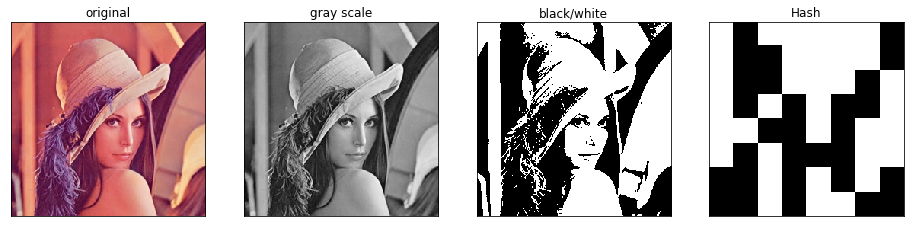

Image Hash of "lenna.png":
binary: 	1011111010011110100111011010100111001011101000110010101000101100
decimal:	4711154807591458259
hexdecimal:	0x41616256345cd5d3


In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

I = Image.open("lenna.png")

plt.figure(figsize=(16,4))
plt.subplot(141); plt.xticks([], []); plt.yticks([], [])
# original picture
I = np.array(I)
plt.imshow(I,interpolation='nearest')
plt.title("original")

plt.subplot(142); plt.xticks([], []); plt.yticks([], [])
# gray scale
I = I.mean(axis=2)
plt.imshow(I,cmap=plt.cm.gray,interpolation='nearest')
plt.title("gray scale")

plt.subplot(143); plt.xticks([], []); plt.yticks([], [])

mean = I.mean()
I = np.int_(I>mean)
plt.imshow(I,cmap=plt.cm.gray,interpolation='nearest')
plt.title("black/white")

plt.subplot(144); plt.xticks([], []); plt.yticks([], [])

I = Image.fromarray(I.astype(np.uint8))
I = I.resize((8,8))
I = np.array(I)

plt.imshow(I,cmap=plt.cm.gray,interpolation='nearest')
plt.title("Hash")
plt.show()

HASH = tuple(I.flatten())
print('Image Hash of "lenna.png":')
print('binary: \t%s'%(''.join(list(map(lambda x:str(x), HASH)))))
deciHASH = sum(map(lambda x: 2**(63-x),list(filter(lambda i: not HASH[i] ,range(64)))))
print('decimal:\t%d'%deciHASH)
print('hexdecimal:\t%s'%hex(deciHASH))

不过由于哈希本身是一种摘要计算（提取主要信息），那么必然的就会出现一个情况，就是不同的输入在同一个哈希函数上得到的结果是一样的，比如哈希函数$y=x\mod 10$，这个哈希函数其实在实际生活中非常常用，举个例子，店老板为防止伙计偷拿店中钱财，一般会记录账目，但记录完整的数目会给账目管理带来很大的压力（尤其是没有电子管理平台时），因此老板就可以记录下当前余额的最末位，比如3，当有一笔新的账目时，比如收入12元，老板就会将收入的末位加到当前总余额的哈希值上，得到5，如果查账时发现余额并不是以5结尾，那么就说明了伙计有偷拿老板的钱。但这有一个问题，比如伙计拿了10元的话，哈希值是不会变的，这时这个方法就失去作用了。这个问题同样会出现在Python字典的底层设计中。

对于Python字典的查询，很小概率会遇到不同对象哈希过后得到的值一样，这时他们原则上是会被分配到一个地址上，但这样的话就会出现冲突，因此实际上，每个目标地址存储的并非值本身，而是一个链表的入口，通过这个入口可以按顺序查找键值对，直到找到目标为止。这样的设计可以避免由于哈希产生的冲突，同时保留了哈希查询时的高效。